# SPEML Exercise 1 - Anonymization

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [2]:
# column names from https://archive.ics.uci.edu/ml/datasets/Adult
header = ["age" ,"workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country", "target"] 

adults = pd.read_csv("../data/adult.data", sep=", ", engine='python', names=header, na_values=["?","nan"], index_col=False)
adults["target"].replace(["<=50K", ">50K"], [0,1], inplace=True)
adults.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0


## Define some re-usable functions

In [3]:
%%file preproc.py

import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

def preproc(data, onehot_encoder=None, scaler=None, numeric=None, categorical=None):
    this_data = data.copy()
    this_data.dropna(inplace=True) # drop all lines with missing values
    this_data.reset_index(inplace=True, drop=True)

    drops = ["education-num"] # drop this since we have education and education-num 
    this_data.drop(columns=drops, axis=1, inplace=True)

    # numericals to scale
    if numeric is None:
        to_scale = ["age", "fnlwgt", "capital-gain", "capital-loss", "hours-per-week"]
    else:
        to_scale = numeric
        if "education-num" in to_scale:
            to_scale.remove("education-num")

    if not scaler:
        this_scaler = MinMaxScaler()
        this_scaler.fit(this_data[to_scale])
    else:
        this_scaler = scaler 
    this_data[to_scale] = this_scaler.transform(this_data[to_scale])

    # categorical columns to encode
    if categorical is None:
        onehot = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
    else:
        onehot = categorical

    # in case no encoder is provided we create one which can then be re-used (train-test split)
    if not onehot_encoder:
        this_enc = OneHotEncoder(handle_unknown='ignore')
        this_enc.fit(this_data[onehot])
    else:
        this_enc = onehot_encoder

    encoded = pd.DataFrame(this_enc.transform(this_data[onehot]).toarray(), columns=this_enc.get_feature_names())
    this_data = pd.concat([this_data.drop(columns=onehot),
                    encoded],
                    axis=1)

    # assert that all went well and we did not loose or add any rows...
    assert(data.dropna().shape[0] == this_data.shape[0])

    return this_data, this_enc, this_scaler

Overwriting preproc.py


In [4]:
%%file classify.py

import time
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
#from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#from sklearn.metrics import average_precision_score

def classify(X_train, y_train, X_test, y_test):   
    names = ["SVC", "RandomForest", "GaussianNB"]

    classifiers = [
        SVC(gamma=2, C=1),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        GaussianNB()]

    results = pd.DataFrame(columns=names, index=["f1", "roc_auc"])

    for i in enumerate(classifiers):
        cname = names[i[0]]
        c = i[1]

        print("Fitting {} now...".format(cname))
        s = time.time()
        c.fit(X_train, y_train)
        print("--- Done! Took {:1.4f}s".format(time.time()-s))
        y_pred = c.predict(X_test)
    
        results[cname]["f1"] = f1_score(y_test, y_pred, average='micro')
        results[cname]["roc_auc"] = roc_auc_score(y_test, y_pred)
    
    return results

Overwriting classify.py


In [5]:
import classify
import preproc

## Pre-Anonymisation

In [7]:
from sklearn.model_selection import train_test_split

adults.dropna(inplace=True)
adults.reset_index(inplace=True, drop=True)

X = adults.drop("target", axis=1)
y = adults["target"].dropna()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
pp_train, encoder, scaler = preproc.preproc(X_train)

pp_test, encoder, scaler = preproc.preproc(X_test, encoder, scaler)

print("Data: ", pp_train.shape[0]+pp_test.shape[0], adults.dropna().shape[0])
print("---    Train, Test")
print("X:    ", pp_train.shape[0], pp_test.shape[0])
print("Y:    ", y_train.shape[0], y_test.shape[0])
pp_train.head(3)

Data:  30162 30162
---    Train, Test
X:     24129 6033
Y:     24129 6033


,age,fnlwgt,capital-gain,capital-loss,hours-per-week,x0_Federal-gov,x0_Local-gov,x0_Private,x0_Self-emp-inc,x0_Self-emp-not-inc,...,x7_Portugal,x7_Puerto-Rico,x7_Scotland,x7_South,x7_Taiwan,x7_Thailand,x7_Trinadad&Tobago,x7_United-States,x7_Vietnam,x7_Yugoslavia
0,0.493151,0.104544,0.0,0.0,0.704082,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.438356,0.028550,0.0,0.0,0.704082,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.150685,0.095040,0.0,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
results_raw = classify.classify(pp_train, y_train, pp_test, y_test)
results_raw

Fitting SVC now...
--- Done! Took 170.6308s
Fitting RandomForest now...
--- Done! Took 0.0480s
Fitting GaussianNB now...
--- Done! Took 0.0440s


,SVC,RandomForest,GaussianNB
f1,0.818001,0.746395,0.534063
roc_auc,0.722302,0.5,0.672556


In [21]:
print(results_raw.to_markdown(tablefmt="github"))

|         |      SVC |   RandomForest |   GaussianNB |
|---------|----------|----------------|--------------|
| f1      | 0.818001 |       0.746395 |     0.534063 |
| roc_auc | 0.722302 |       0.5      |     0.672556 |


---
## Anonymize
Anonymized Quasi-identifiers data with __k-Anonymization__ using **ARX** Javava lib, see ```anonymization/arx.java```
### Quasi-Identifiers
- workclass
- education
- marital-status
- relationship
- native-country
- age
- occupation
- race
- sex


In [52]:
cols_categorical = ["workclass", "education", "marital-status", "relationship", "native-country", "age", "occupation", "race", "sex"]
cols_numerical = set(header)-set(cols_categorical)
cols_numerical.remove('target') # we dont want to use target in preprocessing later
cols_numerical = list(cols_numerical)

ks = [1,5,10,25,50,75,100]
results_anon = []

for k in ks:
    adults_anonym = pd.read_csv("../data/anonymization/k-anonymity/anonymized_k{}.data".format(k), sep=",", engine='python', na_values=["?","nan"], index_col=False)
    adults_anonym["target"].replace(["<=50K", ">50K"], [0,1], inplace=True)

    adults_anonym.dropna(inplace=True)
    adults_anonym.reset_index(inplace=True, drop=True)

    X = adults_anonym.drop("target", axis=1)
    y = adults_anonym["target"].dropna()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    pp_train, encoder, scaler = preproc.preproc(X_train, numeric=cols_numerical, categorical=cols_categorical)

    pp_test, encoder, scaler = preproc.preproc(X_test, encoder, scaler, numeric=cols_numerical, categorical=cols_categorical)

    #print("Data: ", pp_train.shape[0]+pp_test.shape[0], adults.dropna().shape[0])
    print("---    Train, Test")
    print("X:    ", pp_train.shape[0], pp_test.shape[0])
    print("Y:    ", y_train.shape[0], y_test.shape[0])

    results_anon.append(classify.classify(pp_train, y_train, pp_test, y_test))

---    Train, Test
X:     24129 6033
Y:     24129 6033
Fitting SVC now...
--- Done! Took 258.1055s
Fitting RandomForest now...
--- Done! Took 0.0501s
Fitting GaussianNB now...
--- Done! Took 0.0729s
---    Train, Test
X:     24822 6206
Y:     24822 6206
Fitting SVC now...
--- Done! Took 41.1707s
Fitting RandomForest now...
--- Done! Took 0.0453s
Fitting GaussianNB now...
--- Done! Took 0.0185s
---    Train, Test
X:     24916 6230
Y:     24916 6230
Fitting SVC now...
--- Done! Took 28.8092s
Fitting RandomForest now...
--- Done! Took 0.0540s
Fitting GaussianNB now...
--- Done! Took 0.0183s
---    Train, Test
X:     24936 6235
Y:     24936 6235
Fitting SVC now...
--- Done! Took 24.7403s
Fitting RandomForest now...
--- Done! Took 0.0484s
Fitting GaussianNB now...
--- Done! Took 0.0159s
---    Train, Test
X:     25024 6257
Y:     25024 6257
Fitting SVC now...
--- Done! Took 23.4637s
Fitting RandomForest now...
--- Done! Took 0.0557s
Fitting GaussianNB now...
--- Done! Took 0.0142s
---    Tr

In [54]:
_results = pd.DataFrame()
for k, res in zip(ks, results_anon):
    thisr = res.reset_index()
    thisr["k-anon"] = k
    thisr.set_index(["k-anon", "index"], inplace=True)
    _results = pd.concat([_results, thisr])
    
_results

SVC RandomForest GaussianNB
k-anon index                                    
1      f1       0.785679     0.746395   0.477872
       roc_auc  0.631607          0.5   0.640524
5      f1       0.819852     0.756204   0.730583
       roc_auc  0.720331     0.510889   0.778242
10     f1       0.830498     0.779936   0.735634
       roc_auc  0.733086     0.551595   0.782893
25     f1       0.810265     0.794226   0.736167
       roc_auc  0.673988     0.574838    0.77027
50     f1       0.831229     0.797187   0.756433
       roc_auc  0.744608      0.58017   0.779686
75     f1        0.80836     0.785531   0.736334
       roc_auc  0.695632     0.558143   0.767358
100    f1       0.808252     0.792739   0.735327
       roc_auc  0.697279     0.590958   0.762987
250    f1       0.827729     0.822509    0.74405
       roc_auc  0.757746     0.703723    0.76882

In [55]:
print(_results.to_markdown(tablefmt="github"))

|                  |      SVC |   RandomForest |   GaussianNB |
|------------------|----------|----------------|--------------|
| (1, 'f1')        | 0.785679 |       0.746395 |     0.477872 |
| (1, 'roc_auc')   | 0.631607 |       0.5      |     0.640524 |
| (5, 'f1')        | 0.819852 |       0.756204 |     0.730583 |
| (5, 'roc_auc')   | 0.720331 |       0.510889 |     0.778242 |
| (10, 'f1')       | 0.830498 |       0.779936 |     0.735634 |
| (10, 'roc_auc')  | 0.733086 |       0.551595 |     0.782893 |
| (25, 'f1')       | 0.810265 |       0.794226 |     0.736167 |
| (25, 'roc_auc')  | 0.673988 |       0.574838 |     0.77027  |
| (50, 'f1')       | 0.831229 |       0.797187 |     0.756433 |
| (50, 'roc_auc')  | 0.744608 |       0.58017  |     0.779686 |
| (75, 'f1')       | 0.80836  |       0.785531 |     0.736334 |
| (75, 'roc_auc')  | 0.695632 |       0.558143 |     0.767358 |
| (100, 'f1')      | 0.808252 |       0.792739 |     0.735327 |
| (100, 'roc_auc') | 0.697279 |       0.

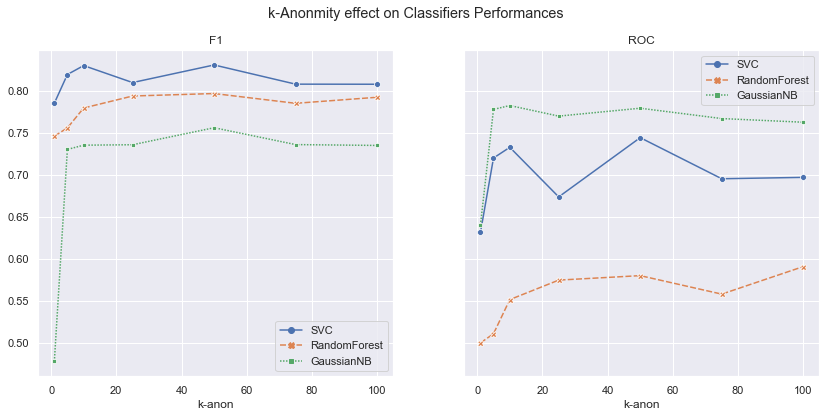

In [97]:
_results["SVC"] = _results.SVC.astype(float)
_results["RandomForest"] = _results.RandomForest.astype(float)
_results["GaussianNB"] = _results.GaussianNB.astype(float)

fig, axes = plt.subplots(1,2, sharey=True, figsize = (14,6))
fig.suptitle("k-Anonmity effect on Classifiers Performances")
sns.lineplot(ax=axes[0], data=_results[:-2].reset_index().set_index("k-anon").query("index=='f1'"),
     ci=None, markers=True )
axes[0].set_title("F1")
sns.lineplot(ax=axes[1], data=_results[:-2].reset_index().set_index("k-anon").query("index=='roc_auc'"),
     ci=None, markers=True )
axes[1].set_title("ROC")

fig.savefig("../report/k-anon.png", dpi=60)

The Generalization from k-Anonymity had a slightly positive effect on the selected classifers. 

Raw data:

|         |      SVC |   RandomForest |   GaussianNB |
|---------|----------|----------------|--------------|
| f1      | 0.816858 |       0.747438 |     0.500904 |
| roc_auc | 0.713279 |       0.5      |     0.653093 |

Anonymization with different k=`[1,2,3,5,10]`:

|                 |      SVC |   RandomForest |   GaussianNB |
|-----------------|----------|----------------|--------------|
| (1, 'f1')       | 0.782098 |       0.747438 |     0.462929 |
| (1, 'roc_auc')  | 0.62063  |       0.5      |     0.632957 |
| (2, 'f1')       | 0.818434 |       0.756131 |     0.620847 |
| (2, 'roc_auc')  | 0.720695 |       0.504954 |     0.721045 |
| (3, 'f1')       | 0.81617  |       0.764237 |     0.715354 |
| (3, 'roc_auc')  | 0.716781 |       0.523024 |     0.770721 |
| (5, 'f1')       | 0.81709  |       0.755176 |     0.725098 |
| (5, 'roc_auc')  | 0.717696 |       0.511436 |     0.77586  |
| (10, 'f1')      | 0.827804 |       0.772838 |     0.727114 |
| (10, 'roc_auc') | 0.728224 |       0.531637 |     0.778962 |

Arguably, the generalization might have helped the classifiers to not overfit on some less important variables, especially on simpler methods like RandomForest or the GaussianNB. 


## Microaggregation